In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,  StandardScaler
from matplotlib.pyplot import (figure, plot, title, xlabel, ylabel, 
                               colorbar, imshow, xticks, yticks, show)
from sklearn import model_selection, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, DistanceMetric
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary, rlr_validate
import numpy as np

import numpy as np
from sklearn.model_selection import KFold
import torch


## Import file

In [3]:
def load():# Load the heart csv data using the Pandas library
    filename = 'heart.csv'
    df = pd.read_csv(filename)
    return df


In [4]:
def outlier_removal(df):
   # Select columns 1 to 18
   selected_columns = df.iloc[:, 0:18]
   # Calculate basic summary statistics
   summary_statistics = selected_columns.describe()

   # Drop the data set to remove outlier
   df = df.drop(df[(df.BMI > summary_statistics.BMI['mean']+2*summary_statistics.BMI['std'])
            & (df.BMI < summary_statistics.BMI['mean']-2*summary_statistics.BMI['std'])
            & (df.PhysicalHealth > summary_statistics.PhysicalHealth['mean']+2*summary_statistics.PhysicalHealth['std'])
            & (df.PhysicalHealth < summary_statistics.PhysicalHealth['mean']-2*summary_statistics.PhysicalHealth['std'])
            & (df.MentalHealth > summary_statistics.MentalHealth['mean']+2*summary_statistics.MentalHealth['std'])
            & (df.MentalHealth < summary_statistics.MentalHealth['mean']-2*summary_statistics.MentalHealth['std'])
            & (df.SleepTime > summary_statistics.SleepTime['mean']+2*summary_statistics.SleepTime['std'])
            & (df.SleepTime < summary_statistics.SleepTime['mean']-2*summary_statistics.SleepTime['std'])].index)
   
   
   return df 

In [5]:
def balanced(df):
    # Balance the data
    # Count the number of 'yes' and 'no' values in the 'label' column
    yes_count = df['HeartDisease'].value_counts()['Yes']
    no_count = df['HeartDisease'].value_counts()['No']

    # Determine the label to balance (either 'yes' or 'no')
    label_to_balance = 'Yes' if yes_count > no_count else 'No'
    label_to_keep = 'Yes' if yes_count <= no_count else 'No'

    #remove after
    columns_to_random = df[df['HeartDisease'] == label_to_keep].sample(n=100, random_state=42)
    
    # Calculate the difference in counts
    #count_diff = yes_count 
    count_diff = 100
    # Get the columns where the label is equal to label_to_balance
    columns_to_balance = df[df['HeartDisease'] == label_to_balance]

    # Randomly sample rows to make the counts equal
    sampled_rows = columns_to_balance.sample(n=count_diff, random_state=42)
    
    

    
    # Concatenate the sampled rows with the rows where the label is equal to label_to_keep
    # balance = pd.concat([df[df['HeartDisease'] == label_to_keep], sampled_rows])
    balance  = pd.concat([columns_to_random, sampled_rows])

    # Shuffle the rows to randomize the order
    balance = balance.sample(frac=1, random_state=42)

    df = balance 
    return df

In [6]:
def encode(df):
    # Transforme the discrete string into integer
    encoder = LabelEncoder()
    for col in df:
        if col != "BMI":
            df[col] = encoder.fit_transform(df[col])
    return df

In [7]:
def data_preprocess():
    df = load()
    df = outlier_removal(df)
    df = balanced(df)
    df = encode(df)
    return df

In [8]:
df = data_preprocess()
print(len(df['HeartDisease']))

200


In [9]:
# Extract the data matrix, the class label and attribute names from the csv
raw_data = df.values

Data = raw_data[:,1:]
Label = df.values [:,0]
Attributes = np.asarray(df.columns[1:].str.slice(0, 3))

In [10]:
# Summary of Dataset in percentages
print(df['HeartDisease'].value_counts(normalize=True) * 100)

1    50.0
0    50.0
Name: HeartDisease, dtype: float64


In [11]:
# Transform to mean of 0 and standard deviation of 1
Data = Data/Data.std(axis=0)
Data = Data - Data.mean(axis=0)

In [12]:
# Assign each type of class with a number by making a Python dictionary
# and extract the class vector y, convert to NumPy array
classNames = np.unique(Label)
classDict = dict(zip(classNames,range(len(classNames))))

y = np.asarray([classDict[value] for value in Label])

In [13]:
# Compute values of number of data(N), attributes(M) and classes(C).
N = len(y)
M = len(Attributes)
C = len(classNames)

# ANN

In [59]:
# Define the hyperparameters grid to search
param_grid = {
    'hidden_units': [2, 4, 8, 16, 32], # number of hidden units
    'reg_param': [0.001, 0.01, 0.1],
    'loss_fn': torch.nn.MSELoss(),
    'max_iter': 10000,
    'n_replicates': 1, # number of networks trained in each k-fold
    'K_inner' : 5,
    'K_outer' : 5
} 
       

# Define a function to create a Keras model with variable hidden units and regularization
def create_model(hidden_units=4,  M=17):
    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
    return model

In [64]:
# Define the outer cross-validation splits
outer_cv = KFold(n_splits=param_grid['K_outer'], shuffle=True, random_state=1)

# Initialize variables to store the best hyperparameter and the corresponding best score
best_hyperparameter = None
best_score = float('inf')  # Initialize with a large value for MSE

# Create a list to store the results for each hyperparameter value
results = []

for ok, (train_outer_index, test_outer_index) in enumerate(outer_cv.split(Data,Label)):
    print('\nCrossvalidation outer fold: {0}/{1}'.format(ok+1,param_grid['K_outer']))   

    X_train_outer, X_test_outer = torch.Tensor(Data[train_outer_index,:] ), torch.Tensor(Data[test_outer_index,:] )
    y_train_outer, y_test_outer = torch.Tensor(Label[train_outer_index]), torch.Tensor(Label[test_outer_index])

     

    par, nn_mse = NN_inner(X_train_outer, X_test_outer,y_train_outer, y_test_outer)
    # Store the best hyperparameter value and its corresponding score (MSE) for this outer fold
    results.append((par, nn_mse))

print(results)
# Find the best hyperparameter value and its corresponding score (MSE) across all outer folds
best_hyperparameter, best_score = min(results, key=lambda x: x[1])
print(best_hyperparameter, best_score)


Crossvalidation outer fold: 1/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.25035292	6.4281858e-06
		Final loss:
		1297	0.2501108	9.532509e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		548	0.24905857	9.572782e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.25010157	1.4299285e-06
		Final loss:
		1041	0.25008857	9.5333564e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		906	0.24980819	9.544057e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		716	0.24785441	9.61929e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		939	0.25012755	9.5318705e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		825	0.2491672	9.568608e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.25021935	1.6674643e-06
		Final loss:
		1181	0.25015867	9.5306854e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		816	0.2498462	8.9461923e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		768	0.24793984	9.615976e-07

	Replicate: 1/1
	

In [65]:
def NN_inner(X_train_outer, X_test_outer,y_train_outer, y_test_outer ):
    # Initialize variables to keep track of the best hyperparameter and score within this outer fold
    best_fold_hyperparameter = None
    best_fold_score = float('inf')
    
    for n_hidden in param_grid['hidden_units']:
        # Define the inner cross-validation splits
        inner_cv = KFold(n_splits=param_grid['K_inner'], shuffle=True, random_state=1)

        errors = []
        for ik, (train_index, test_index) in enumerate(inner_cv.split(X_train_outer,y_train_outer)): 

            print('\nCrossvalidation fold: {0}/{1}'.format(ik+1,param_grid['K_inner']))    
            
            # Extract training and test set for current CV fold, 
            # and convert them to PyTorch tensors
            X_train = torch.Tensor(Data[train_index,:] )
            y_train = torch.Tensor(Label[train_index] )
            X_test = torch.Tensor(Data[test_index,:] )
            y_test = torch.Tensor(Label[test_index] )
            
            model = create_model(n_hidden,M)
            # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
            # and see how the network is trained (search for 'def train_neural_net',
            # which is the place the function below is defined)
            net, final_loss, learning_curve = train_neural_net(model,
                                                            param_grid['loss_fn'],
                                                            X=X_train,
                                                            y=y_train,
                                                            n_replicates=param_grid['n_replicates'],
                                                            max_iter=param_grid['max_iter'])
            
            
            
            # Determine estimated class labels for test set
            y_test_est = net(X_test).squeeze()
            
            # Determine errors and errors
            se = (y_test_est.float()-y_test.float())**2 # squared error
            mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
            errors.append(mse) # store error rate for current CV fold 
            # print('\n\tBest loss: {}'.format(final_loss), 'mse: {}\n'.format(mse))
        # Calculate the average score for this hyperparameter value across inner folds
        Eavg = np.mean(errors)

        # Check if this hyperparameter value is better than the previous best within this outer fold
        if Eavg < best_fold_score:
            best_fold_score = Eavg
            best_fold_hyperparameter = n_hidden
            
    model = create_model(n_hidden,M)
    # Train the model with the best hyperparameter on the entire training set (X_train_outer, y_train_outer)
    Outer_net, Outer_final_loss, Outer_learning_curve = train_neural_net(model,
                                                                        param_grid['loss_fn'],
                                                                        X=X_train_outer,
                                                                        y=y_train_outer,
                                                                        n_replicates=param_grid['n_replicates'],
                                                                        max_iter=param_grid['max_iter'])

    # Determine estimated class labels for test set
    y_test_outer_est = Outer_net(X_test_outer).squeeze()
            
    # Determine errors and errors
    Outer_se = (y_test_outer_est.float()-y_test_outer.float())**2 # squared error
    Outer_mse = (sum(se).type(torch.float)/len(y_test_outer)).data.numpy() #mean
    print('\n\tBest loss: {}'.format(final_loss), 'mse: {}\n'.format(Outer_mse))

    

    return (best_fold_hyperparameter, round(Outer_mse.item(),2))

# KNN

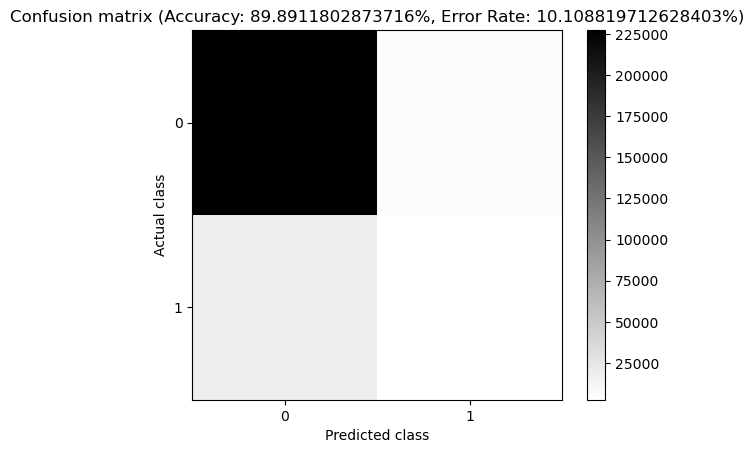

In [ ]:
K=3

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist= 2
#metric = 'minkowski'
#metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine' 
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                    metric=metric,
                                    metric_params=metric_params)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# # Plot the classfication results
# styles = ['ob', 'or', 'og', 'oy']
# for c in range(C):
#     class_mask = (y_est==c)
#     plot(X_test[class_mask,0], X_test[class_mask,1], styles[c], markersize=10)
#     plot(X_test[class_mask,0], X_test[class_mask,1], 'kx', markersize=8)
# title('Synthetic data classification - KNN');

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est);
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
figure(2);
imshow(cm, cmap='binary', interpolation='None');
colorbar()
xticks(range(C)); yticks(range(C));
xlabel('Predicted class'); ylabel('Actual class');
title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

show()


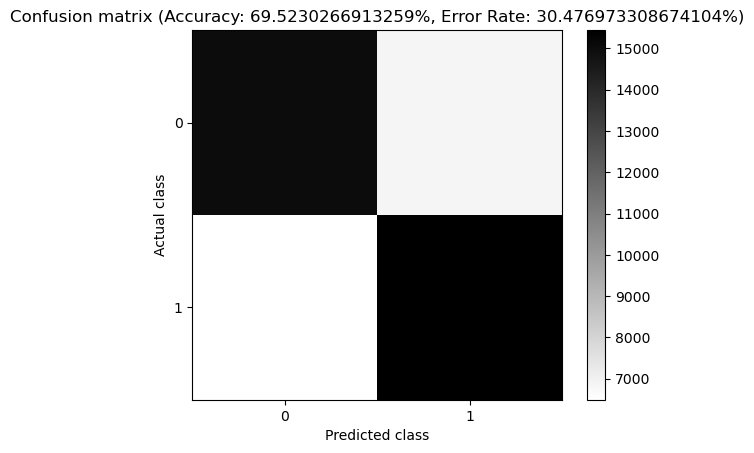

In [ ]:
K=3

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist= 2
#metric = 'minkowski'
#metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine' 
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                    metric=metric,
                                    metric_params=metric_params)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# # Plot the classfication results
# styles = ['ob', 'or', 'og', 'oy']
# for c in range(C):
#     class_mask = (y_est==c)
#     plot(X_test[class_mask,0], X_test[class_mask,1], styles[c], markersize=10)
#     plot(X_test[class_mask,0], X_test[class_mask,1], 'kx', markersize=8)
# title('Synthetic data classification - KNN');

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est);
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
figure(2);
imshow(cm, cmap='binary', interpolation='None');
colorbar()
xticks(range(C)); yticks(range(C));
xlabel('Predicted class'); ylabel('Actual class');
title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

show()
